In [7]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
from sklearn.decomposition import PCA
import pickle as pck

## 1.1 2d double well: Potential definition and visualisation

C:\Users\Sri Vatsa\AppData\Local\Temp\ipykernel_8916\3223759710.py:41: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(contour, label= 'Potential V(x, y)')


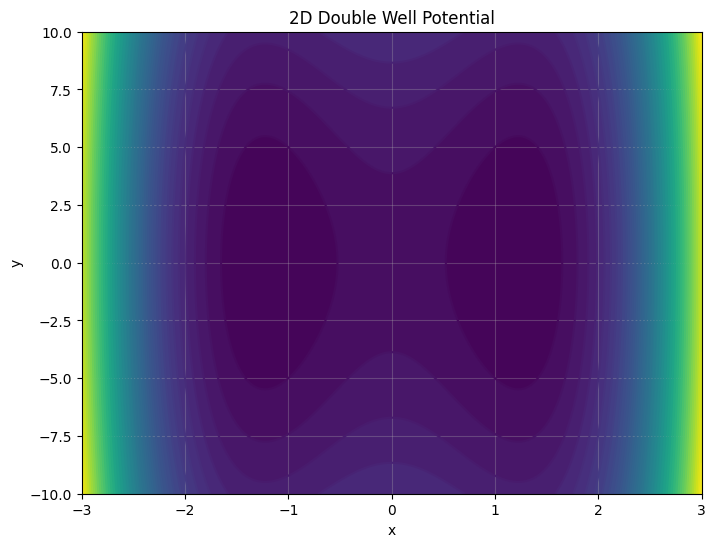

In [6]:
# potential V(x, y)
def Vpot(r):
    x, y = r
    return (x**2 -1.5)**2 + 0.05 * y**2

# dV/dx 
def Vpot_dx(r):
    x, y = r
    return 4 * x * (x**2 - 1.5)

# dV/dy
def Vpot_dy(r):
    x, y = r
    return 0.1 * y

# compute kinetic energy E_kin = 0.5 * |v|^2
def Ekin(v):
    vx, vy = v
    return 0.5 * (vx**2 + vy**2)

# check if particle is in A or B
def in_A(r):
    x, y = r
    return x < -0.8
    
def in_B(r):
    x, y = r
    return x > 0.8

# Visualisation of the potential
x_vals = np.linspace(-3, 3, 300)
y_vals = np.linspace(-10, 10, 300)
X, Y = np.meshgrid(x_vals, y_vals)

# Compute potential over the grid
V = Vpot((X, Y))

# Plot the potential
plt.figure(figsize= (8,6))
contour = plt.contourf(X, Y, V, levels= 50, cmap='viridis')
plt.contour(contour, label= 'Potential V(x, y)')
plt.title('2D Double Well Potential')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(alpha=0.3)
plt.show()

## 1.2 MD step function

In [8]:
# MD step using the langevin dynamics
rng = default_rng(23)  #random no generator


def mdstep(r, v, f, dt, lc):
    """
    We perform one MD step using Langevin dynamics

    Parameters
    ----------
    r: array, current positions
    v: array, current velocities
    f: array, current forces
    dt: float, time step
    lc: array, Langevin coefficients [c1, c2]

    Returns
    ---------
    r: updated positions
    v: updated velocities
    f: updated forces
    """

    # mass is set to 1.0 here, does not explicitly appear in the equations

    # langevin thermo, 1st half step
    v = lc[0] * v + lc[1] * rng.standard_normal(size=2)  # Langevin thermostat (1st half step)

    # Verlet part of MD step
    v += 0.5 * f * dt               # Velocity Verlet (half step) 
    r += dt * v                     # update position           

    # compute forces for new position, dVdx and dVdy are the partial derivatives wrt x and y
    f = np.array([-Vpot_dx(r), -Vpot_dy(r)])    # update forces

    v += 0.5 * f * dt               # Velocity Verlet (second half step)

    # langevin thermostat, 2nd half step
    v = lc[0] * v + lc[1] * rng.standard_normal(size=2)

    return r, v, f

## 1.2 MD Simulation example

In [16]:
# set time step and temperature
dt = 0.05
beta = 4.0

# initialize random number generator
rng = default_rng(27)

# initialize langevin parameters
lgamma = 1.0
c1 = np.exp(-lgamma*dt/2.0)
c2 = np.sqrt((1.0 - c1**2) / beta)
lc = np.array([c1,c2])
steps = int(1e5)

# initialize position, velocities, and forces
r = np.array([0.0,0.0])
v = np.sqrt(1.0 / beta) * rng.standard_normal(size=2)  # Initialize velocity
f = np.array([-Vpot_dx(r), -Vpot_dy(r)])  # Initial force

# you need to add the function to compute Ekin
scale = np.sqrt(1.0/beta/Ekin(v))   # Rescale to init v target temperature
v = v*scale                         # Rescale to match target temperature

print(f'Initial beta = {1.0/Ekin(v):.3f}')

# Storage for positions
positions = []
sum_Ekin = 0.0
count = 0
output_interval = 1000
save_interval = 100

# Run simulation
for step in range(steps):
    r, v, f = mdstep(r, v, f, dt, lc)
    count += 1
    sum_Ekin += Ekin(v)
    
    # Save positions at intervals
    if step % save_interval == 0:
        positions.append(r.copy())

    # Print output at intervals
    if step % output_interval == 0:
        avg_beta = 1.0 / (sum_Ekin / count)
        print(f"Step {step}, x = {r[0]:.3f}, y = {r[1]:.3f}, avg beta = {avg_beta:.3f}, A = {in_A(r)}, B = {in_B(r)}")

# Convert positions to numpy array
positions = np.array(positions)


Initial beta = 4.000
Step 0, x = 0.035, y = 0.012, avg beta = 3.072, A = False, B = False
Step 1000, x = 1.166, y = 0.922, avg beta = 4.005, A = False, B = True
Step 2000, x = 0.982, y = 0.034, avg beta = 3.953, A = False, B = True
Step 3000, x = 1.116, y = -0.393, avg beta = 3.828, A = False, B = True
Step 4000, x = 1.226, y = 1.743, avg beta = 3.777, A = False, B = True
Step 5000, x = 1.062, y = -0.340, avg beta = 3.788, A = False, B = True
Step 6000, x = 1.284, y = 0.723, avg beta = 3.901, A = False, B = True
Step 7000, x = 1.296, y = -0.456, avg beta = 3.852, A = False, B = True
Step 8000, x = 1.126, y = -2.344, avg beta = 3.884, A = False, B = True
Step 9000, x = 1.105, y = 0.242, avg beta = 3.876, A = False, B = True
Step 10000, x = 1.182, y = -0.457, avg beta = 3.865, A = False, B = True
Step 11000, x = 1.094, y = 1.385, avg beta = 3.901, A = False, B = True
Step 12000, x = 1.332, y = -1.338, avg beta = 3.913, A = False, B = True
Step 13000, x = 0.922, y = 1.379, avg beta = 3.86

### Plot of position as function of time

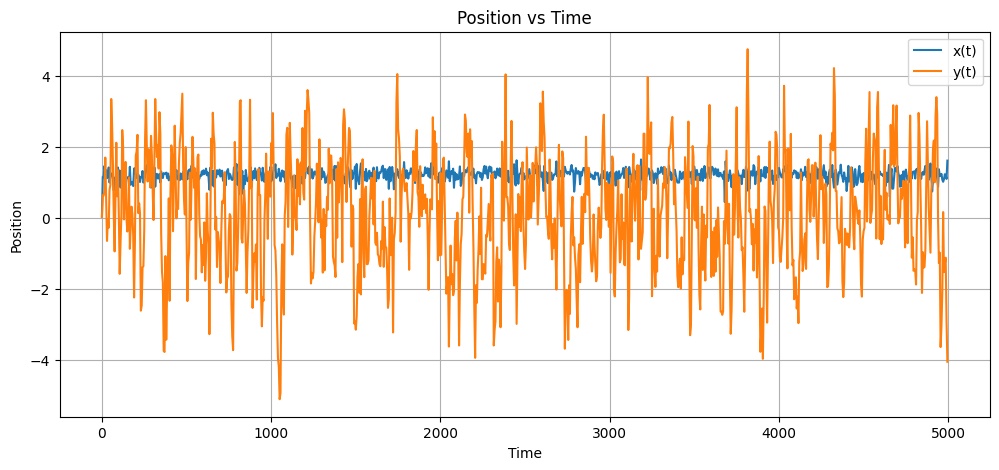

In [17]:
time = np.arange(len(positions)) * save_interval * dt
plt.figure(figsize=(12, 5))
plt.plot(time, positions[:, 0], label='x(t)')
plt.plot(time, positions[:, 1], label='y(t)')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Position vs Time')
plt.legend()
plt.grid()
plt.show()

### Scatter plot of trajectory

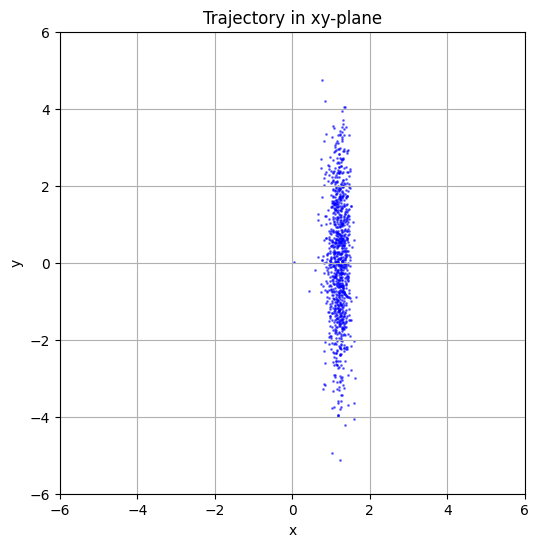

In [18]:
plt.figure(figsize=(6, 6))
plt.scatter(positions[:, 0], positions[:, 1], s=1, alpha=0.5, c='blue')
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory in xy-plane')
plt.grid()
plt.show()

## 1.3 PCA


In [19]:
def pca(X, num_components):
    """ Performs PCA for a given number of components. Returns reduced data and eigenvectors (principal components).

    Parameters:
    -----------
    X : Array to perform PCA on.
    num_components : Number of principal components of interest.
    """
    # subtract mean
    x = X - np.mean(X, axis=0)

    # covariance matrix
    cov_mat = np.cov(x, rowvar=False)

    # Diagonalize covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov_mat)

    # Sort
    sorted_ids = np.argsort(eigvals)[::-1]
    eigvecs_sorted = eigvecs[:, sorted_ids]

    # Select requested eigenvectors
    eigvecs_selected = eigvecs_sorted[:, 0:num_components]

    # Project data onto eigenvectors
    X_projected = np.dot(eigvecs_selected.transpose(), x.transpose()).transpose()

    return X_projected, eigvecs_selected

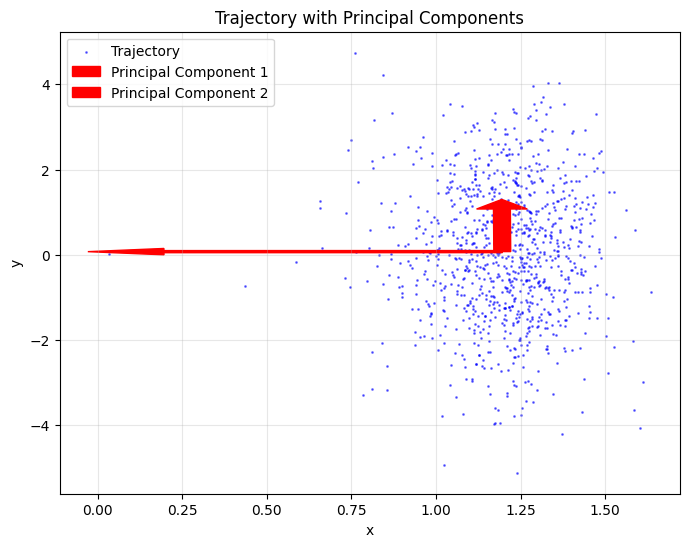

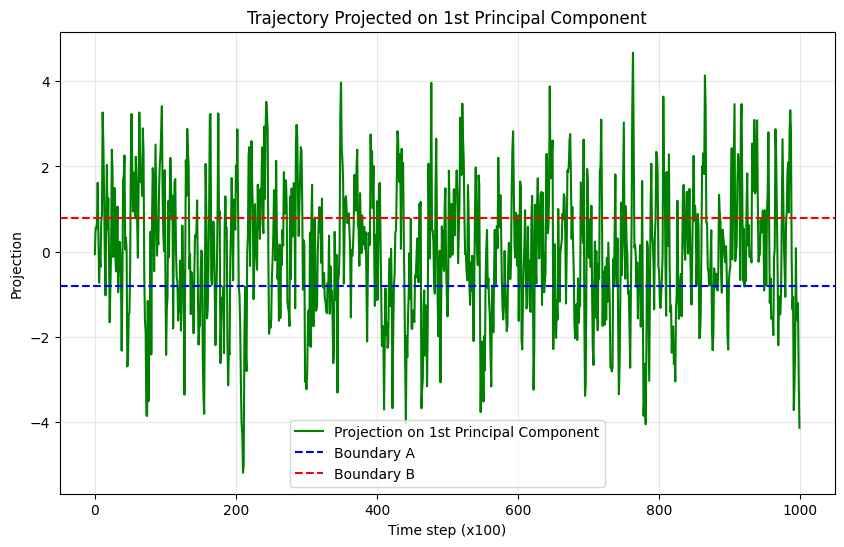

In [ ]:
# Perform PCA on trajectory data
X_projected, eigvecs_selected = pca(positions, num_components=2)

# Visualization: Scatter plot with principal components
plt.figure(figsize=(8, 6))
plt.scatter(positions[:, 0], positions[:, 1], c="blue", s=1, alpha=0.5, label="Trajectory")
mean_position = np.mean(positions, axis=0)
for i, eigvec in enumerate(eigvecs_selected.T):
    plt.arrow(
        mean_position[0],
        mean_position[1],
        eigvec[0],
        eigvec[1],
        color="red",
        width=0.05,
        label=f"Principal Component {i + 1}",
    )
plt.title("Trajectory with Principal Components")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Visualization: Projection onto the first principal component
plt.figure(figsize=(10, 6))
plt.plot(X_projected[:, 0], label="Projection on 1st Principal Component", color="green")
plt.axhline(-0.8, color="blue", linestyle="--", label="Boundary A")
plt.axhline(0.8, color="red", linestyle="--", label="Boundary B")
plt.title("Trajectory Projected on 1st Principal Component")
plt.xlabel("Time step (x100)")
plt.ylabel("Projection")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 2. z -potential

## 2.1 Potential visualisation

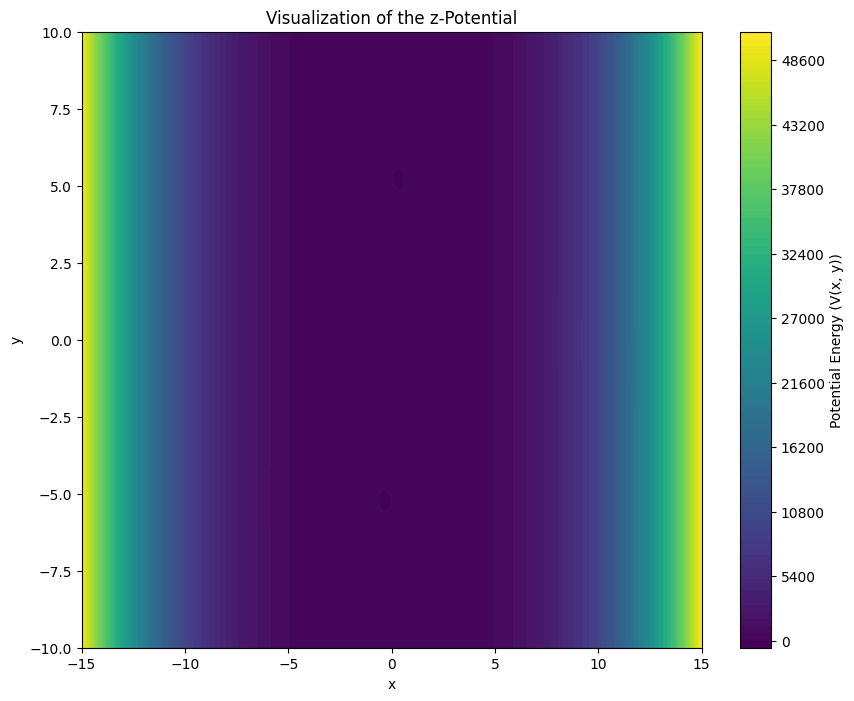

In [ ]:
# Define z-potential V(x, y) and plot the z-potential
def Vpot_z(r):
    x, y = r
    term1 = x**4 + y**4 / 20480
    term2 = -3 * np.exp(-0.01 * (x + 5)**2 - 0.2 * (y + 5)**2)
    term3 = -3 * np.exp(-0.01 * (x - 5)**2 - 0.2 * (y - 5)**2)
    term4 = 5 * np.exp(-0.2 * (x + 3 * (y - 3))**2) / (1 + np.exp(-x - 3))
    term5 = 5 * np.exp(-0.2 * (x + 3 * (y + 3))**2) / (1 + np.exp(x - 3))
    term6 = 3 * np.exp(-0.01 * (x**2 + y**2))
    return term1 + term2 + term3 + term4 + term5 + term6

# Gradients of V(x, y)
def Vpot_z_dx(r):
    x, y = r
    # Partial derivative wrt x (calculated analytically)
    dx_term1 = 4 * x**3
    dx_term2 = 3 * 0.02 * (x + 5) * np.exp(-0.01 * (x + 5)**2 - 0.2 * (y + 5)**2)
    dx_term3 = 3 * 0.02 * (x - 5) * np.exp(-0.01 * (x - 5)**2 - 0.2 * (y - 5)**2)
    dx_term4 = 5 * (-0.4 * (x + 3 * (y - 3))) * np.exp(-0.2 * (x + 3 * (y - 3))**2) / (1 + np.exp(-x - 3))
    dx_term5 = 5 * (-0.4 * (x + 3 * (y + 3))) * np.exp(-0.2 * (x + 3 * (y + 3))**2) / (1 + np.exp(x - 3))
    dx_term6 = 3 * 0.02 * x * np.exp(-0.01 * (x**2 + y**2))
    return dx_term1 + dx_term2 + dx_term3 + dx_term4 + dx_term5 + dx_term6

def Vpot_z_dy(r):
    x, y = r
    # Partial derivative wrt y (calculated analytically)
    dy_term1 = (4 * y**3) / 20480
    dy_term2 = 3 * 0.4 * (y + 5) * np.exp(-0.01 * (x + 5)**2 - 0.2 * (y + 5)**2)
    dy_term3 = 3 * 0.4 * (y - 5) * np.exp(-0.01 * (x - 5)**2 - 0.2 * (y - 5)**2)
    dy_term4 = 5 * (-1.2 * (y - 3)) * np.exp(-0.2 * (x + 3 * (y - 3))**2) / (1 + np.exp(-x - 3))
    dy_term5 = 5 * (-1.2 * (y + 3)) * np.exp(-0.2 * (x + 3 * (y + 3))**2) / (1 + np.exp(x - 3))
    dy_term6 = 3 * 0.02 * y * np.exp(-0.01 * (x**2 + y**2))
    return dy_term1 + dy_term2 + dy_term3 + dy_term4 + dy_term5 + dy_term6

# Define range for x and y
x_vals = np.linspace(-15, 15, 300)
y_vals = np.linspace(-10, 10, 300)
X, Y = np.meshgrid(x_vals, y_vals)

# Compute potential values
Z = Vpot_z((X, Y))

# Plot the z-potential
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, Z, levels=100, cmap='viridis')
plt.colorbar(label="Potential Energy (V(x, y))")
plt.title("Visualization of the z-Potential")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## 2.2 MD

In [23]:
# Run Langevin MD Simulation
# We update the MD simulation loop to use the new potential V_z(x, y)

# set new time step and temperature
dt = 0.05
beta = 1.5

# initialize langevin parameters
lgamma = 1.0
c1 = np.exp(-lgamma*dt/2.0)
c2 = np.sqrt((1.0 - c1**2) / beta)
lc = np.array([c1,c2])
steps = int(1e7)

# initialize position, velocities, and forces
r = np.array([0.0,0.0])
v = np.sqrt(1.0 / beta) * rng.standard_normal(size=2)  # Initialize velocity
f = np.array([-Vpot_z_dx(r), -Vpot_z_dy(r)])  # Initial force

# you need to add the function to compute Ekin
scale = np.sqrt(1.0/beta/Ekin(v))   # Rescale to init v target temperature
v = v*scale                         # Rescale to match target temperature

# Storage for positions
positions = []
output_interval = int(1e6)
save_interval = 1000

# Run simulation
for step in range(steps):
    r, v, f = mdstep(r, v, f, dt, lc)
    if step % save_interval == 0:
        positions.append(r.copy())
    if step % output_interval == 0:
        avg_beta = 1.0 / (np.mean([Ekin(v) for v in positions]))
        print(f"Step {step}, x = {r[0]:.3f}, y = {r[1]:.3f}, avg beta = {avg_beta:.3f}, A = {in_A(r)}, B = {in_B(r)}")

positions = np.array(positions)


Step 0, x = 0.062, y = -0.005, avg beta = 525.620, A = False, B = False
Step 1000000, x = 0.977, y = -0.556, avg beta = 0.248, A = False, B = True
Step 2000000, x = -1.043, y = -1.587, avg beta = 0.246, A = True, B = False
Step 3000000, x = -1.171, y = 1.638, avg beta = 0.253, A = True, B = False
Step 4000000, x = 0.939, y = 4.150, avg beta = 0.248, A = False, B = True
Step 5000000, x = 0.871, y = -0.677, avg beta = 0.248, A = False, B = True
Step 6000000, x = -0.824, y = 2.417, avg beta = 0.249, A = True, B = False
Step 7000000, x = -0.175, y = -0.764, avg beta = 0.247, A = False, B = False
Step 8000000, x = -1.515, y = -2.425, avg beta = 0.245, A = True, B = False
Step 9000000, x = 1.760, y = -3.363, avg beta = 0.246, A = False, B = True


## 2.3 PCA

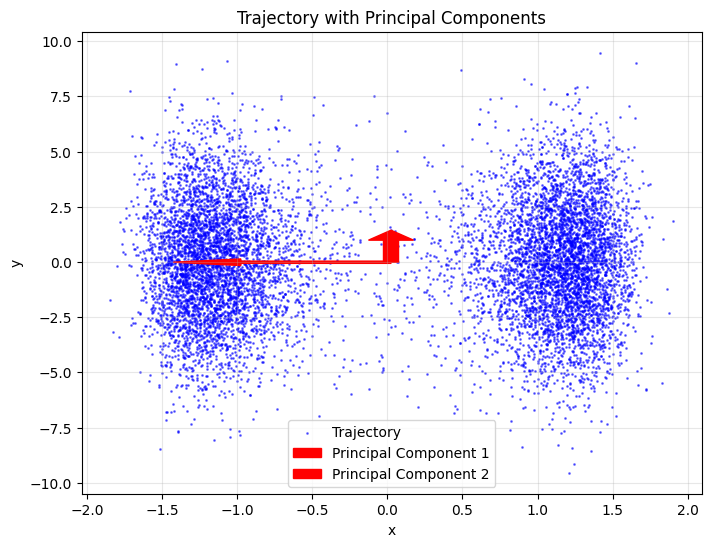

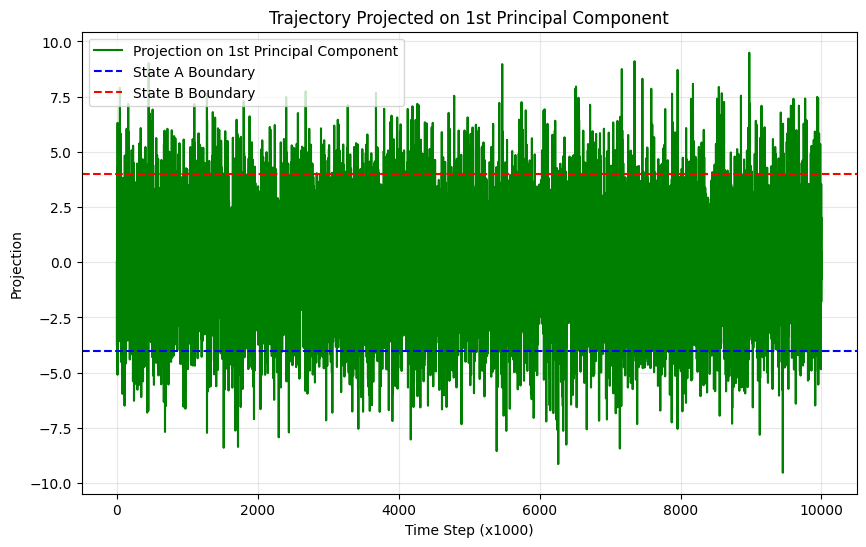

In [25]:
# Perform PCA
X_projected, eigvecs_selected = pca(positions, num_components=2)

# Scatter plot with principal components
plt.figure(figsize=(8, 6))
plt.scatter(positions[:, 0], positions[:, 1], c="blue", s=1, alpha=0.5, label="Trajectory")
mean_position = np.mean(positions, axis=0)
for i, eigvec in enumerate(eigvecs_selected.T):
    plt.arrow(
        mean_position[0],
        mean_position[1],
        eigvec[0],
        eigvec[1],
        color="red",
        width=0.1,
        label=f"Principal Component {i + 1}",
    )
plt.title("Trajectory with Principal Components")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Projection on the first principal component
plt.figure(figsize=(10, 6))
plt.plot(X_projected[:, 0], label="Projection on 1st Principal Component", color="green")
plt.axhline(-4.0, color="blue", linestyle="--", label="State A Boundary")
plt.axhline(4.0, color="red", linestyle="--", label="State B Boundary")
plt.title("Trajectory Projected on 1st Principal Component")
plt.xlabel("Time Step (x1000)")
plt.ylabel("Projection")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
